# Tutorial 2: Fast Diffusion
A big challeng in diffusion models, is the cost of inference. Due to the multi-step generation, the inference is costly but also grants us more flexibility. DDPMs ofter requires too many time steps than is reasonable.

In order to address this problem, we can apply DDIM to skip some sampling steps e.g., from step 10 directly to step 20 (sample the hidden variable of step 20 in condition with the sampled hidden variable of step 10) rather than go through 11, 12 ..., 19, 20. DDIM uses a deterministic reverse process unlike DDPM's stochastic reverse process. This gives us analytic functions for multiple time steps, while retaining sufficient image quality. 

# 2A: DDIM
DDIM is not a training method. It is a new sampling method rather than a new diffusion model. Therefore, when we apply DDIM, we can use DDPM to train the model then use DDIM to do the inference.

100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


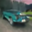

Loading pipeline components...:  40%|████      | 2/5 [00:00<00:01,  2.21it/s]An error occurred while trying to fetch C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to r

In [ ]:
from diffusers import DDIMPipeline, DDIMScheduler, UNet2DModel
from IPython.display import display
import torch
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# google/ddpm-cifar10    google/ddpm-church-256
repo_id = "google/ddpm-cifar10"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loading a pretrained unet
unet = UNet2DModel.from_pretrained(repo_id).to(device)
# loading the corresponding training configuration
scheduler = DDIMScheduler.from_config(repo_id)
ddim_pipe = DDIMPipeline(unet, scheduler).to(device)


res = ddim_pipe(num_inference_steps=50)
image = res.images[0]

display(image)

### Prepare model downloads
import transformers
from diffusers import DiffusionPipeline
transformers.utils.import_utils.is_torch_greater_or_equal = lambda x: True
ldm = DiffusionPipeline.from_pretrained("CompVis/ldm-text2im-large-256").to(device=device)

from diffusers import UNet2DConditionModel, DDIMScheduler, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer

dtype = torch.float16 if torch.cuda.is_available() else torch.float32
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype).to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=dtype).to(device)
unet2 = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)
scheduler2 = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


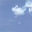

In [40]:
res = ddim_pipe(num_inference_steps=1000)
image = res.images[0]
display(image)

100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


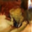

In [41]:
res = ddim_pipe(num_inference_steps=100)
image = res.images[0]
display(image)

100%|██████████| 10/10 [00:00<00:00, 13.66it/s]


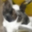

In [42]:
res = ddim_pipe(num_inference_steps=10)
image = res.images[0]
display(image)

100%|██████████| 2/2 [00:00<00:00, 13.44it/s]


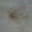

In [43]:
res = ddim_pipe(num_inference_steps=2)
image = res.images[0]
display(image)

There should be a trade-off between sampling steps and image quality.

For DDIM, we can visualize the full sampling stages using the following code.

torch.Size([1, 3, 32, 32])


'Image at step 10'

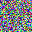

'Image at step 20'

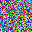

'Image at step 30'

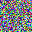

'Image at step 40'

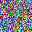

'Image at step 50'

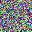

'Image at step 60'

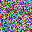

'Image at step 70'

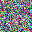

'Image at step 80'

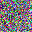

'Image at step 90'

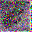

'Image at step 100'

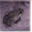

In [44]:
import PIL.Image
import numpy as np
import torch

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

noisy_sample=torch.randn(1, unet.config.in_channels, unet.config.sample_size,
                         unet.config.sample_size)

unet = unet.to(device)
noisy_sample = noisy_sample.to(device)

print(noisy_sample.shape)

scheduler.set_timesteps(100)
sample=noisy_sample

for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        residual=unet(sample,t).sample

    sample =scheduler.step(residual, t, sample).prev_sample

    if (i+1)%10==0:
        display_sample(sample, i+1)

DDIM is also applied on latent diffusion models, LDMs. We can choose the sampling steps of the inference of a LDM.


Device: cuda:0, dtype: torch.float16


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


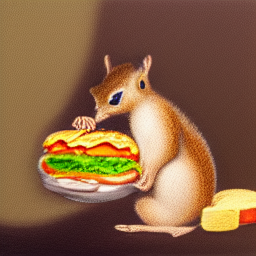

In [45]:
from IPython.display import display
print(f"Device: {ldm.device}, dtype: {dtype}")
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=10, eta=0.3, guidance_scale=6).images

display(images[0])

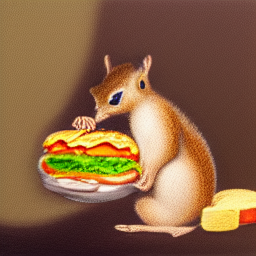

100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


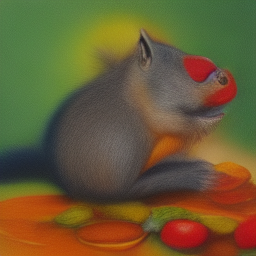

In [46]:
display(images[0])
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=5, eta=0.3, guidance_scale=6).images
display(images[0])

100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


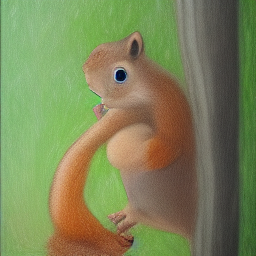

In [47]:
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=5, eta=0.3, guidance_scale=6).images

display(images[0])

In [48]:
from IPython.display import display, clear_output
from tqdm import tqdm
from PIL import Image


def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual prompt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].to(dtype)



def prompt_2_img(prompts, g=7.5, seed=100, steps=50, dim=512, save_int=True, scale_down=8):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet2.in_channels, dim//scale_down, dim//scale_down))

    # Setting number of steps in scheduler
    scheduler2.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to(device=device, dtype=dtype) * scheduler2.init_noise_sigma

    print("Processing text prompts:", prompts)
    
    # Calculate initial latents norm
    initial_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    
    # Iterating through defined steps with enhanced progress bar
    pbar = tqdm(scheduler2.timesteps, desc=f"Generating (init_norm: {initial_norm:.2f})")
    for i, ts in enumerate(pbar):
        # We need to scale the i/p latents to match the variance
        inp = scheduler2.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet2(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler2.step(pred, ts, latents).prev_sample

        # Calculate current latents norm and update progress bar
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        pbar.set_postfix({
            'step': f"{i+1}/{steps}",
            'norm': f"{latents_norm:.2f}",
            'timestep': f"{ts.item():.0f}"
        })

        if save_int and i%10==0:
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

Processing text prompts: ['A dog wearing a hat']


Generating (init_norm: 128.50): 100%|██████████| 50/50 [02:33<00:00,  3.07s/it, step=50/50, norm=111.38, timestep=1]  


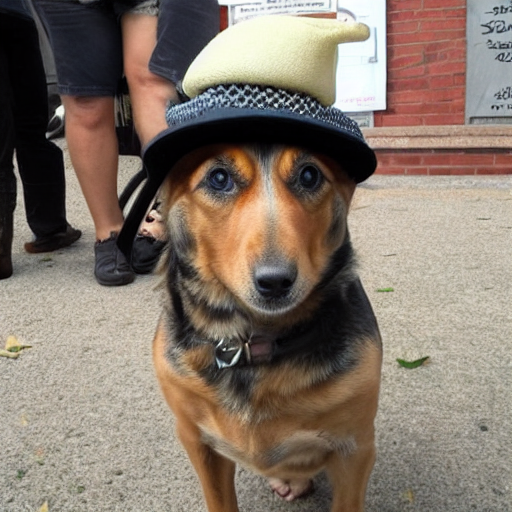

In [49]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=8)
for img in images:
    display(img)

Processing text prompts: ['A dog wearing a hat']


Generating (init_norm: 63.47): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s, step=50/50, norm=67.12, timestep=1]  


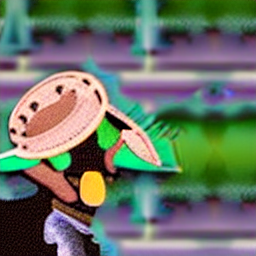

In [50]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=16)
for img in images:
    display(img)